In [216]:
import sys
import os
root_dir = '/home/qing/Desktop/Closed-Loop-Learning/HINT/'
os.chdir(root_dir)
from train import *
from data.domain import OPERATORS
import pandas as pd 
from collections import OrderedDict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.argv = []
args = parse_args()
args.input = 'symbol'
args.model = 'TRAN.relative_universal'
args.resume = f'./models/{args.input}.{args.model}/model_100000.p'
args.nhead = 8
args.enc_layers = 6
args.dec_layers = 1
args.hid_dim = 512
args.max_rel_pos = 15
args

Namespace(batch_size=128, cos_sim_margin=0.2, curriculum='no', dec_layers=1, dropout=0.5, early_stop=None, emb_dim=128, enc_layers=6, epochs=10, epochs_eval=1, fewshot=None, grad_clip=5.0, hid_dim=512, input='symbol', iterations=None, iterations_eval=None, layers=1, lr=0.001, lr_scheduler='constant', main_dataset_ratio=0, max_op_train=None, max_rel_pos=15, model='TRAN.relative_universal', nhead=8, output_dir='outputs/', perception_pretrain='data/perception_pretrain/model.pth.tar_78.2_match', pos_emb_type='sin', result_encoding='decimal', resume='./models/symbol.TRAN.relative_universal/model_100000.p', save_model=False, seed=0, train_size=None, wandb='HINT', warmup_steps=100)

In [3]:
train_set = HINT('train', input=args.input, fewshot=args.fewshot, 
                    n_sample=args.train_size, max_op=args.max_op_train,
                    main_dataset_ratio=args.main_dataset_ratio)
val_set = HINT('val', input=args.input, fewshot=args.fewshot)
test_set = HINT('test', input=args.input, fewshot=args.fewshot)
print('train:', len(train_set), 'val:', len(val_set), 'test:', len(test_set))

args.train_set = train_set
args.val_set = val_set
args.test_set = test_set

train: 998000 val: 4698 test: 46620


In [4]:
args.res_enc = ResultEncoding(args.result_encoding)
model = make_model(args)
if args.resume:
    print('Load checkpoint from ' + args.resume)
    ckpt = torch.load(args.resume)
    model.load_state_dict(ckpt['model_state_dict'])
model.to(DEVICE)

n_params = sum(p.numel() for p in model.parameters())
print('Num params:', n_params)

Load checkpoint from ./models/symbol.TRAN.relative_universal/model_100000.p
Num params: 8019469


In [5]:
dataset = args.test_set
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                            shuffle=False, num_workers=4, collate_fn=HINT_collate)

model.eval() 
res_all = []
res_pred_all = []

expr_all = []
expr_pred_all = []

dep_all = []
dep_pred_all = []

metrics = OrderedDict()

with torch.no_grad():
    for sample in tqdm(dataloader):
        if args.input == 'image':
            src = sample['img_seq']
        elif args.input == 'symbol':
            src = torch.tensor([x for s in sample['sentence'] for x in s])
        res = sample['res']
        if args.result_encoding == 'sin':
            tgt = res.unsqueeze(1)
        else:
            tgt = torch.tensor(args.res_enc.res2seq_batch(res.numpy()))
        expr = sample['expr']
        dep = sample['head']
        src_len = sample['len']

        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        output = model(src, tgt[:, :-1], src_len)
        pred = torch.argmax(output, -1).detach().cpu().numpy()
        if args.result_encoding == 'sin':
            res_pred = pred
        else:
            res_pred = args.res_enc.seq2res_batch(pred)
        res_pred_all.append(res_pred)
        res_all.append(res)

        # expr_pred_all.extend(expr_preds)
        expr_all.extend(expr)
        # dep_pred_all.extend(dep_preds)
        dep_all.extend(dep)

res_pred_all = np.concatenate(res_pred_all, axis=0)
res_all = np.concatenate(res_all, axis=0)
result_acc = (res_pred_all == res_all).mean()
metrics['result_acc/avg'] = result_acc

tracked_attrs = ['length', 'symbol', 'digit', 'result', 'eval', 'tree_depth', 'ps_depth', 'max_dep']
for attr in tracked_attrs:
    # print(f"result accuracy by {attr}:")
    attr2ids = getattr(dataloader.dataset, f'{attr}2ids')
    for k, ids in sorted(attr2ids.items()):
        res = res_all[ids]
        res_pred = res_pred_all[ids]
        res_acc = (res == res_pred).mean() if ids else 0.
        k = 'div' if k == '/' else k
        metrics[f'result_acc/{attr}/{k}'] = res_acc
        # print(k, "(%2d%%)"%(100*len(ids)//len(dataloader.dataset)), "%5.2f"%(100 * res_acc))

100%|█████████████████████████████████████████| 729/729 [00:21<00:00, 34.71it/s]


In [53]:
def compute_max_dep(heads):
    return max([0] + [abs(i-h) for i, h in enumerate(heads) if h != -1])

from functools import lru_cache
def compute_tree_depth(head):
    @lru_cache
    def depth(i):
        """The depth of node i."""
        if head[i] == -1:
            return 1
        return depth(head[i]) + 1

    return max(depth(i) for i in range(len(head)))

lps = '('
rps = ')'
def compute_ps_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

def compute_n_op(expr):
    return len([1 for x in expr if x in OPERATORS])

tracked_attrs = ['eval', 'length', 'tree_depth', 'ps_depth', 'max_dep', 'n_op', 'result']
attr2data = {}
for attr in tracked_attrs:
    data = []
    for sample in dataset:
        if attr == 'length':
            d = len(sample['expr'])
        elif attr == 'result':
            d = sample['res']
        elif attr == 'tree_depth':
            d = compute_tree_depth(sample['head'])
        elif attr == 'max_dep':
            d = compute_max_dep(sample['head'])
        elif attr == 'ps_depth':
            d = compute_ps_depth(sample['expr'])
        elif attr == 'n_op':
            d = compute_n_op(sample['expr'])
        elif attr == 'eval':
            d = sample['eval']
        else:
            assert False
        data.append(d)
    attr2data[attr] = data
attr2data['pred'] = res_pred_all == res_all

In [54]:
df = pd.DataFrame(attr2data)
df

,eval,length,result,tree_depth,ps_depth,max_dep,n_op,pred
0,I,1,7,1,0,0,0,True
1,I,1,1,1,0,0,0,True
2,I,1,0,1,0,0,0,True
3,I,1,6,1,0,0,0,True
4,I,1,4,1,0,0,0,True
...,...,...,...,...,...,...,...,...
46615,LL,67,3,10,6,44,20,False
46616,LL,61,1638,8,4,30,20,False
46617,LL,61,1,9,4,47,20,True
46618,LL,55,5,9,2,28,20,False


In [120]:
df_filter = df[df['eval'] != 'I']
df_filter.groupby(['length', 'n_op', 'result']).get_group((35, 15, 10)).groupby(['max_dep', 'tree_depth'])['pred'].mean()

KeyError: (35, 15, 10)

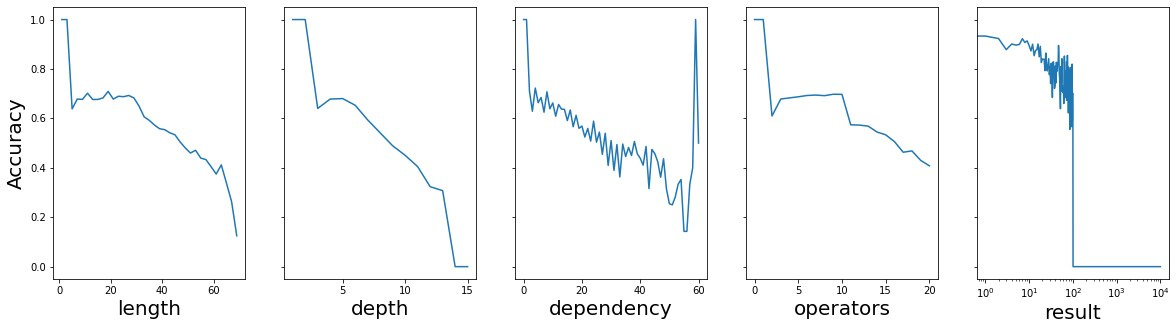

In [254]:
df_filter = df
fontsize = 20
columns = [x for x in tracked_attrs if x not in ['ps_depth', 'eval']]
name_mapping = {'tree_depth': 'depth', 'max_dep': 'dependency', 'n_op': 'operators'}
fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
for i, attr in enumerate(columns):
    gb = df_filter.groupby(attr)
    means, stds = gb.mean()['pred'], gb.std()['pred']
    groups = means.index.get_level_values(0)
    x = np.array(groups)
    y = np.array(means)
    axs[i].plot(x, y)
    if attr == 'result':
        axs[i].set_xscale('log')
    axs[i].set_xlabel(name_mapping.get(attr, attr), fontsize=fontsize)
axs[0].set_ylabel('Accuracy', fontsize=fontsize)
plt.savefig('results/figures/acc_property.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [237]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        if isinstance(values, tuple):
            values, stds = values
        else:
            stds = None
        
        # The offset in x direction of that bar
        offset = (i - n_bars / 2) * bar_width + bar_width / 2
        x = np.arange(len(values)) + offset 

        if stds is not None:
            ax.bar(x, values, yerr=stds, width=bar_width * single_width, color=colors[i % len(colors)], label=name)
        else:
            ax.bar(x, values, width=bar_width * single_width, color=colors[i % len(colors)], label=name)

/tmp/ipykernel_164657/548300733.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['result'] = np.log(X['result']+1e-6)


Fit accuracy:  0.9817635270541082
Feature: length, Score: 0.35647 +/- 0.05240
Feature: tree_depth, Score: 0.15197 +/- 0.03677
Feature: max_dep, Score: 0.19137 +/- 0.04050
Feature: n_op, Score: 0.10319 +/- 0.03408
Feature: result, Score: 0.19700 +/- 0.02298
Fit accuracy:  0.972875


/tmp/ipykernel_164657/548300733.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['result'] = np.log(X['result']+1e-6)


Feature: length, Score: 0.15719 +/- 0.02448
Feature: tree_depth, Score: 0.14389 +/- 0.01965
Feature: max_dep, Score: 0.22249 +/- 0.04531
Feature: n_op, Score: 0.23337 +/- 0.02877
Feature: result, Score: 0.24305 +/- 0.02897


/tmp/ipykernel_164657/548300733.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['result'] = np.log(X['result']+1e-6)


Fit accuracy:  0.8506
Feature: length, Score: 0.18724 +/- 0.00518
Feature: tree_depth, Score: 0.20293 +/- 0.00524
Feature: max_dep, Score: 0.20685 +/- 0.00351
Feature: n_op, Score: 0.19307 +/- 0.00462
Feature: result, Score: 0.20991 +/- 0.00956
Fit accuracy:  0.9834490740740741


/tmp/ipykernel_164657/548300733.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['result'] = np.log(X['result']+1e-6)


Feature: length, Score: 0.05023 +/- 0.00236
Feature: tree_depth, Score: 0.07054 +/- 0.00333
Feature: max_dep, Score: 0.09276 +/- 0.00383
Feature: n_op, Score: 0.04683 +/- 0.00293
Feature: result, Score: 0.73964 +/- 0.00946


/tmp/ipykernel_164657/548300733.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['result'] = np.log(X['result']+1e-6)


Fit accuracy:  0.9259
Feature: length, Score: 0.10543 +/- 0.00608
Feature: tree_depth, Score: 0.09469 +/- 0.00434
Feature: max_dep, Score: 0.09781 +/- 0.00295
Feature: n_op, Score: 0.09875 +/- 0.00362
Feature: result, Score: 0.60331 +/- 0.00425


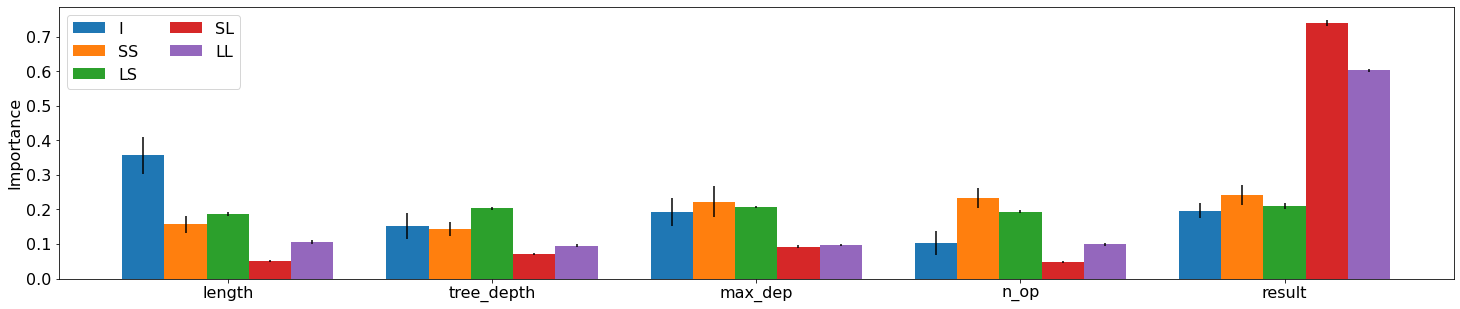

In [238]:
# permutation feature importance with knn for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

evaluations = ['I', 'SS', 'LS', 'SL', 'LL']


# define dataset
columns = [x for x in tracked_attrs if x not in ['ps_depth', 'eval']]

data_bars = OrderedDict()
for i, e in enumerate(evaluations):
    df_filter = df[df['eval'] == e]
    X = df_filter[columns]
    X['result'] = np.log(X['result']+1e-6)
    X = (X - X.mean()) / X.std()
    y = df_filter['pred']
    # define the model
    model = KNeighborsClassifier(n_neighbors=3)
    # fit the model
    model.fit(X, y)
    print('Fit accuracy: ', model.score(X, y))
    # perform permutation importance
    results = permutation_importance(model, X, y, scoring='accuracy')
    # get importance
    importance = results.importances_mean
    importance_std = results.importances_std
    importance_std /= importance.sum()
    importance /= importance.sum()
    # summarize feature importance
    for attr,v,d in zip(columns, importance, importance_std):
        print('Feature: %s, Score: %.5f +/- %.5f' % (attr,v, d))
    # plot feature importance
    data_bars[e] = (importance, importance_std)

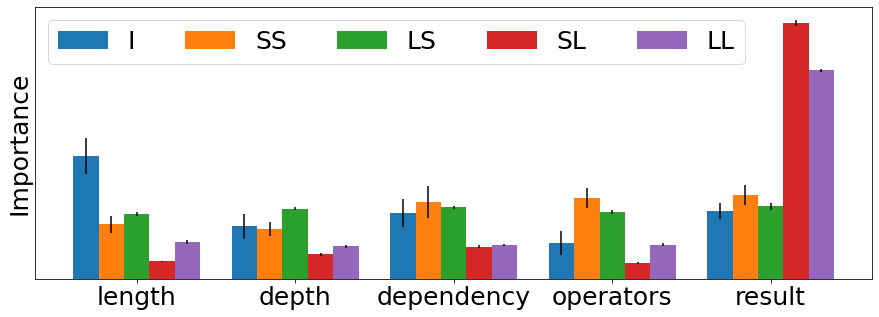

In [251]:
fig, ax = plt.subplots(figsize=(15, 5))
fontsize = 25
bar_plot(ax, data_bars)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
pos = np.arange(len(columns))
plt.yticks([])
plt.xticks(pos, [name_mapping.get(x,x) for x in columns], fontsize=fontsize)
# plt.xlabel('Symbol')
plt.ylabel('Importance', fontsize=fontsize)

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(ncol=len(columns), fontsize=fontsize)

plt.savefig('results/figures/importance.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
error_ids = [i for i, (x, y) in enumerate(zip(res_all, res_pred_all)) if x != y ]

In [21]:
symbol_images_dir = root_dir + 'data/symbol_images/'
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('L', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def show_sample(sample, show_image=True):
    print(sample['expr'], len(sample['expr']))
    if show_image:
        img = render_img(sample['img_paths'])
        display(img)

In [25]:
for i in range(len(dataset)):
    sample = dataset.dataset[i]
#     if sample['eval'] not in ['LL']: continue
    if sample['res'] < 100: continue
    print(sample['expr'], len(sample['expr']), max(sample['res_all']))
    print(res_all[i], res_pred_all[i])
    input()

8*(8*9) 7 576
576 64


6*(9+9) 7 108
108 98


6*(9+8) 7 102
102 92


9*(2*7) 7 126
126 36


8*8*2 5 128
128 64


(9+5)*8 7 112
112 96


8*7*6 5 336
336 56


9*4*9 5 324
324 36


9*(5*6) 7 270
270 90


8*3*6 5 144
144 84


8*(6+8) 7 112
112 96


7*5*7 5 245
245 35


7*5*8 5 280
280 70


(8+9)*9 7 153
153 63


7*(3*5) 7 105
105 95


2*6*9 5 108
108 78


9*4*6 5 216
216 96


5*8*9 5 360
360 90


7*2*8 5 112
112 96


9*8*8 5 576
576 64


6*(6*8) 7 288
288 48


6*(5*5) 7 150
150 90


6*7*8 5 336
336 96


5*7*9 5 315
315 95


(6+9)*8 7 120
120 90


6*4*8 5 192
192 96


(8+9)*8 7 136
136 96


(6+9)*7 7 105
105 95


9*(5*3) 7 135
135 15


9*(9+9) 7 162
162 72


(6+7)*8 7 104
104 94


6*9*6 5 324
324 54


5*9*8 5 360
360 80


8*7*7 5 392
392 56


7*(6*8) 7 336
336 56


4*(9*4) 7 144
144 36


8*(7+8) 7 120
120 90


4*(4*7) 7 112
112 96


4*4*7 5 112
112 96


7*9*7 5 441
441 63


6*(6*7) 7 252
252 42


9*(4*4) 7 144
144 54


7*4*5 5 140
140 100


9*7*8 5 504
504 64


9*(6*9) 7 486
486 54


3*9*9 5 243
243 81


7*(7*9) 7 441
441 63


9*4*7 5 252
252 72


6*(9*6) 7 324
324 54


6*(9*3) 7 162
162 72


8*(7*7) 7 392
392 96


8*(9*5) 7 360
360 90


(9+9)*9 7 162
162 72


9*(7*5) 7 315
315 35


7*5*3 5 105
105 95


4*5*6 5 120
120 90


8*(8+9) 7 136
136 56


4*9*6 5 216
216 96


3*8*9 5 216
216 36


6*4*7 5 168
168 98


8*(6+9) 7 120
120 90


9*(4*6) 7 216
216 36


9*(6*8) 7 432
432 72


3*9*8 5 216
216 64


6*(7*8) 7 336
336 96


6*(5*7) 7 210
210 90


8*(7*4) 7 224
224 56


8*8*7 5 448
448 56


8*(9+8) 7 136
136 56


8*(8+5) 7 104
104 94


4*8*8 5 256
256 96


(8+4)*9 7 108
108 72


9*(7*4) 7 252
252 72


9*(6*5) 7 270
270 90


KeyboardInterrupt: Interrupted by user